In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("brooklyn (1).csv")

In [4]:
df.head()

,id,date_collected,retailer_type,retailer_detail,food_type,food_detail,label_type,label_language,label_date,approximate_dollar_value,image_id,collection_lat,collection_long,label_explanation
0,5e31d5503b85a2e63d634187,2020-01-27,counter service,ready-to-eat and prepackaged health food,ready-to-eat,organic oatmeal,sticker,use by,2020-01-28,5.25,IMG_1872,40.69453,-73.99447,NaN
1,5e31d5643b85a2e63d634188,2020-01-27,counter service,ready-to-eat and prepackaged health food,ready-to-eat,organic oatmeal,sticker,use by,2020-01-28,5.25,IMG_1873,40.69453,-73.99447,NaN
2,5e31d8903b85a2e63d634189,2020-01-27,counter service,ready-to-eat and prepackaged health food,ready-to-eat,organic middle eastern salad,sticker,use by,2020-01-28,10.00,IMG_1874,40.69453,-73.99447,NaN
3,5e31dcee3b85a2e63d63418a,2020-01-27,counter service,ready-to-eat and prepackaged health food,ready-to-eat,organic oatmeal,sticker,use by,2020-01-28,6.25,IMG_1875,40.69453,-73.99447,NaN
4,5e31dd273b85a2e63d63418b,2020-01-27,counter service,ready-to-eat and prepackaged health food,ready-to-eat,organic mexican salad,sticker,use by,2020-01-28,10.00,IMG_1876,40.69453,-73.99447,NaN


In [5]:
df['date_collected'] = pd.to_datetime(df['date_collected'], errors='coerce')

In [6]:
df['label_date'] = pd.to_datetime(df['label_date'], errors='coerce')

In [7]:
df = df[df['label_date'].notna()]

In [8]:
df['diff'] = df['label_date']-df['date_collected']

In [9]:
# removing outliers

df = df[(df['diff'] > df['diff'].quantile(.05)) & (df['diff'] < df['diff'].quantile(0.95))]

In [10]:
df['diff'] = df['diff'].astype('str').apply(lambda x: x.split(' ')[0]).astype('int')

In [11]:
df_labels = df.groupby('label_language').agg({'id':'count', 'diff':'mean'})
df_labels.columns = ['count','diff']

In [12]:
df_labels.nlargest(5, 'count')

,count,diff
label_language,,
sell by,31,0.903226
sell thru,25,-0.520000
exp,14,-1.428571
use by,14,0.214286
best if used by,5,-0.200000


<AxesSubplot:xlabel='label_language'>

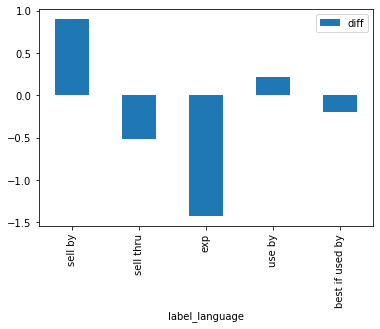

In [13]:
df_labels.nlargest(5, 'count').plot.bar(y='diff')

<AxesSubplot:xlabel='retailer_type'>

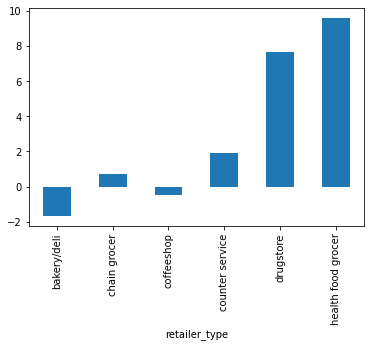

In [14]:
df.groupby('retailer_type')['diff'].mean().plot(kind='bar')

In [15]:
df.groupby('retailer_type').count().id.to_frame().sort_values(by='id', ascending=False)

,id
retailer_type,
drugstore,39
chain grocer,34
bakery/deli,31
health food grocer,30
counter service,9
coffeeshop,2


In [16]:
df[df['retailer_type']=='health food grocer']['food_type'].value_counts()

perishable    30
Name: food_type, dtype: int64

In [17]:
df[df['retailer_type']=='drugstore']['food_type'].value_counts()

perishable      23
ready-to-eat    10
packaged         6
Name: food_type, dtype: int64

<AxesSubplot:xlabel='food_type'>

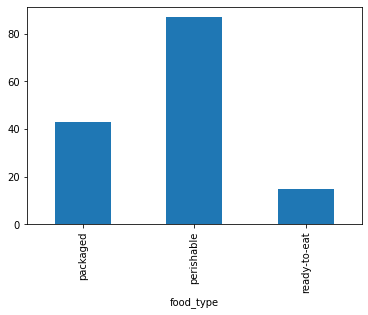

In [18]:
df.groupby('food_type')['id'].count().plot(kind='bar')

In [19]:
df_food = df.groupby('food_detail').agg({'id':'count', 'diff':'mean'}).sort_values(by='id', ascending=False).head(10).reset_index()

In [20]:
df_food.columns = ['food_detail','count','diff']

In [21]:
df_food

,food_detail,count,diff
0,yogurt,17,1.882353
1,flatbread pepperoni pizza,7,0.000000
2,honey turkey and swiss wrap,7,-2.714286
3,pasteurized grade a goat milk,5,3.000000
4,mixed fruit cup,5,-0.200000
5,red velvet cake slice,4,3.500000
6,organic riced cauliflower,4,-1.000000
7,organic energy bar,4,3.000000
8,california roll sushi,4,-1.000000
9,chocolate cake,3,1.000000


<AxesSubplot:xlabel='food_detail'>

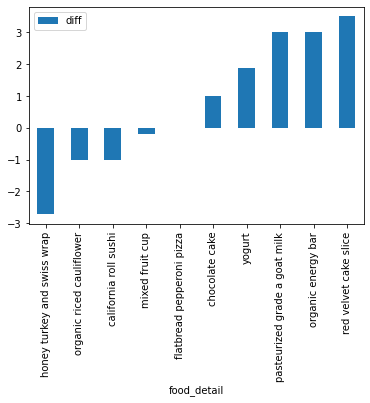

In [22]:
df_food.sort_values(by='diff').plot.bar(x='food_detail',y='diff')

In [23]:
df_r = df.groupby(['retailer_type', 'food_detail'])['diff'].mean().to_frame().reset_index()

In [24]:
dup = df_r[df_r['food_detail'].duplicated()]

In [26]:
df_duplicates = df[df['food_detail'].apply(lambda x: x in dup['food_detail'].to_list())]

In [27]:
df_duplicates = df_duplicates.groupby(['retailer_type', 'food_detail']).agg({'diff':'mean','id':'count'})
df_duplicates.columns = ['diff','count']
df_duplicates.head()

,,diff,count
retailer_type,food_detail,,
bakery/deli,cut cantaloupe,-2.000000,1
chain grocer,cut cantaloupe,0.000000,2
drugstore,yogurt,2.133333,15
health food grocer,yogurt,0.000000,2


In [28]:
df['organic'] = df['food_detail'].apply(lambda x: ('organic' in x)*1)

In [29]:
df.groupby('organic')['diff'].sum()

organic
0    454
1    121
Name: diff, dtype: int32

In [30]:
df.groupby('organic')['diff'].mean()

organic
0    3.752066
1    5.041667
Name: diff, dtype: float64